# Energy Forcasting - Time Series Analysis Using XGBoost

### Objective

Load forcasting is a critical problem in the energy sector. It is a technique used by electricity companies to predict the power needed for the demand and supply. It allows for better planning and management of resources and not only helps in reducing the cost of electricity but also helps in reducing the carbon footprint by reducing the wastage of energy. (Journal Article: https://www.mdpi.com/2071-1050/15/9/7087)

In this notebook, we will approach this problem using a regression analysis using XGBoost to forecast the general energy load. 

Load forecasting is concerned with the prediction of hourly, daily, weekly and monthly values of load and of the peak load.

![alt text](DataSet/images/energyforcasting.png "Energy Load Map")

### Dataset
Refer to README.md for more information on the dataset.

### Limitations

Unfortunately, the availible data does not separate the data into different energy sources, so we will be using the general energy load as a whole. Whereas in reality, the energy load is made up of different sources such as coal, nuclear, hydro, wind, solar which all are effected differently by each feature. For example, solar energy is dependent on the time of day and weather, whereas nuclear energy is not. 

Model Limitations: 

With XGBoost, we are limited by only being able to predict the future based within the range of historic values. This means that we are not able to predict any future events that may effect the energy load


### Features 

The most commonly come from seasonal data (time of day, holidays), historical data (past electricity loads), weather data (temperature), and human mobility data (tourism, work).

## Imports and Setup

In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

from utils.clean_data import mean_std_outliers, missing_data
from utils.preprocess import create_timeseries_features, add_lags
from utils.plot import plot_train_test_split, plot_mean_monthly, plot_time_range, plot_feature_importance
from utils.train import cross_validation, tune_hyperparameters

colour_pal = sns.color_palette('flare')
sns.set_palette(colour_pal)
plt.style.use('fivethirtyeight')

In [2]:
TARGET_CUTOFF_DATE = '01-01-2016'

### Load Dataset & Convert Date Column 


In [3]:
df = pd.read_csv(
    './DataSet/Regions/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [4]:
df.head()


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


Check for missing values

In [5]:
missing_data(df)

,Total,Percent,Types
PJME_MW,0,0.0,float64


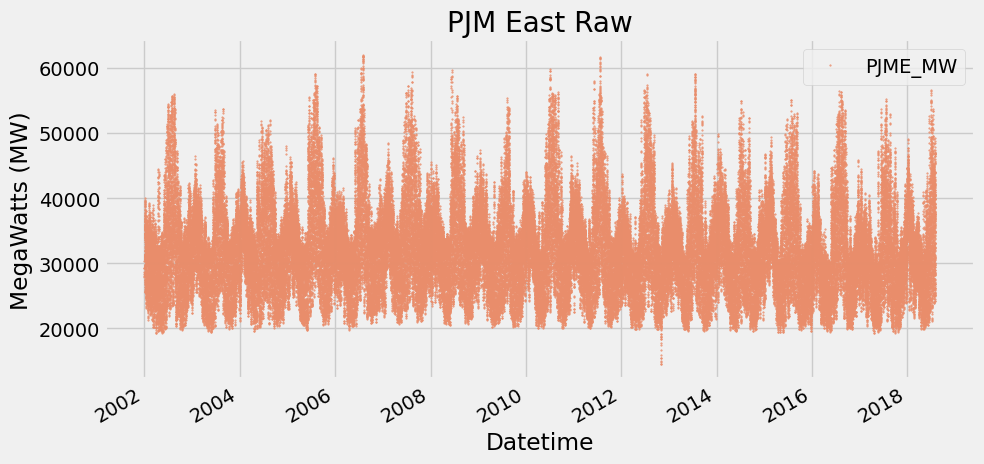

In [6]:
df.plot(style='.', figsize=(10, 5), ms=1, color=colour_pal,
          ylabel='MegaWatts (MW)', title='PJM East Raw')

plt.show()

## Data Preprocessing

In [7]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


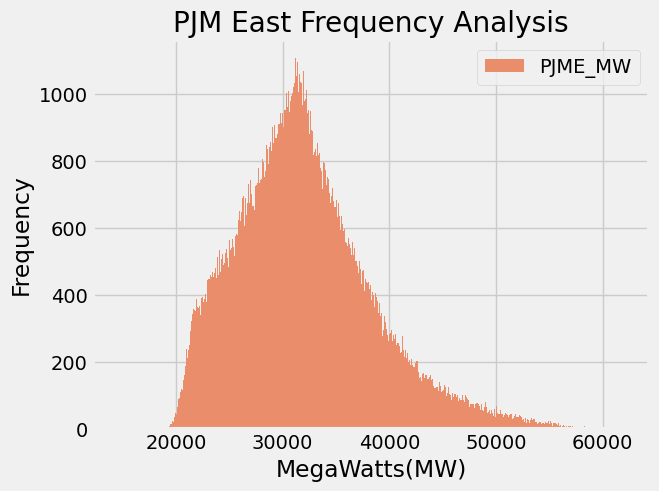

In [8]:
df.plot(kind='hist', bins=500, color=colour_pal,
          xlabel='MegaWatts(MW)', title='PJM East Frequency Analysis')
plt.show()

In [8]:
upper_threshold, lower_threshold = mean_std_outliers(df)
print(lower_threshold.max(), upper_threshold.min())

Outlier threshold calculations: Lower threshold:                     PJME_MW
Datetime                    
2012-10-31 02:00:00  18618.0
2012-10-31 03:00:00  18350.0
2012-10-31 04:00:00  18330.0
2012-10-31 05:00:00  18880.0
2012-10-30 01:00:00  15390.0
2012-10-30 02:00:00  14955.0
2012-10-30 03:00:00  14586.0
2012-10-30 04:00:00  14544.0
2012-10-30 05:00:00  14821.0
2012-10-30 06:00:00  15526.0
2012-10-30 07:00:00  16688.0
2012-10-30 08:00:00  17734.0
2012-10-30 09:00:00  18675.0
2012-10-29 22:00:00  19085.0
2012-10-29 23:00:00  17422.0
2012-10-30 00:00:00  15919.0 Upper threshold:                      PJME_MW
Datetime                    
2002-08-19 14:00:00  52145.0
2002-08-19 15:00:00  53094.0
2002-08-19 16:00:00  53575.0
2002-08-19 17:00:00  53739.0
2002-08-19 18:00:00  53202.0
...                      ...
2018-07-01 18:00:00  51803.0
2018-06-18 16:00:00  51818.0
2018-06-18 17:00:00  52558.0
2018-06-18 18:00:00  52213.0
2018-06-18 19:00:00  51597.0

[1318 rows x 1 columns]
PJME_MW    

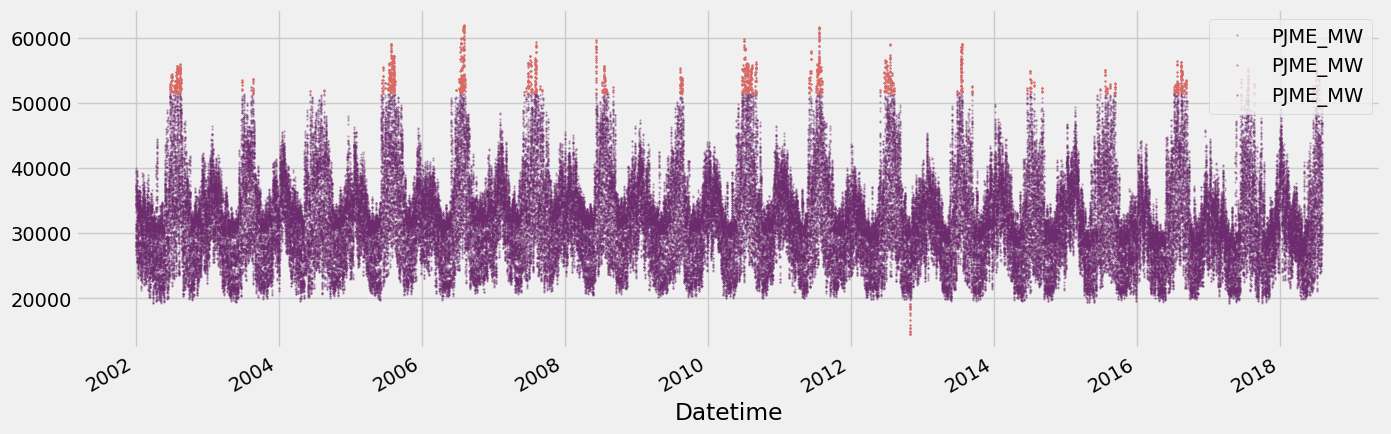

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
df.plot(style='.', ms=1, color=colour_pal[5], alpha=0.5, ax=ax)
upper_threshold.plot(style='.', ax=ax, ms=1, color=colour_pal[1])
lower_threshold.plot(style='.', ax=ax, ms=1, color=colour_pal[1])
plt.show()

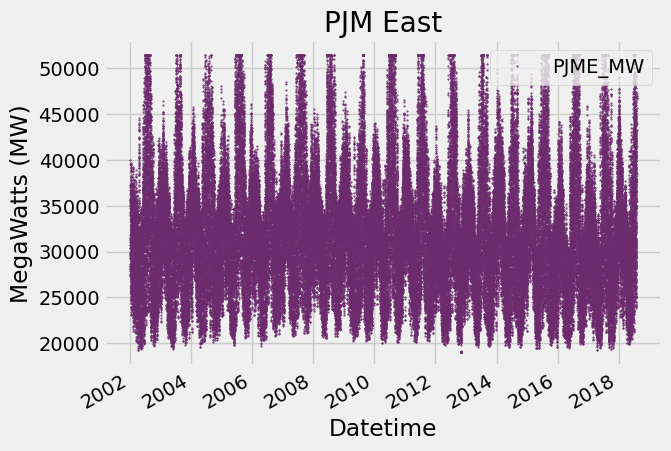

<Figure size 640x480 with 0 Axes>

In [11]:
df['PJME_MW'] = df['PJME_MW'].clip(upper=51472, lower=19085).copy()
df.plot(style='.', ms=1, color=colour_pal[5],
          ylabel='MegaWatts (MW)', title='PJM East')
plt.show()
plt.clf()

## Feature Engineering

In [10]:
df_features = create_timeseries_features(df)

In [11]:
df_features.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


### USA Holidays

In [12]:
cal = calendar()
holidays = cal.holidays(start=df.index.min(),
                        end=df.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index': 'ds'})
holiday_df

,ds,holiday
0,2002-01-21,"Birthday of Martin Luther King, Jr."
1,2002-02-18,Washington's Birthday
2,2002-05-27,Memorial Day
3,2002-07-04,Independence Day
4,2002-09-02,Labor Day
...,...,...
159,2018-01-01,New Year's Day
160,2018-01-15,"Birthday of Martin Luther King, Jr."
161,2018-02-19,Washington's Birthday
162,2018-05-28,Memorial Day


## EDA - Visualize Feature to Target Relationship

### Energy Load Data By Hour

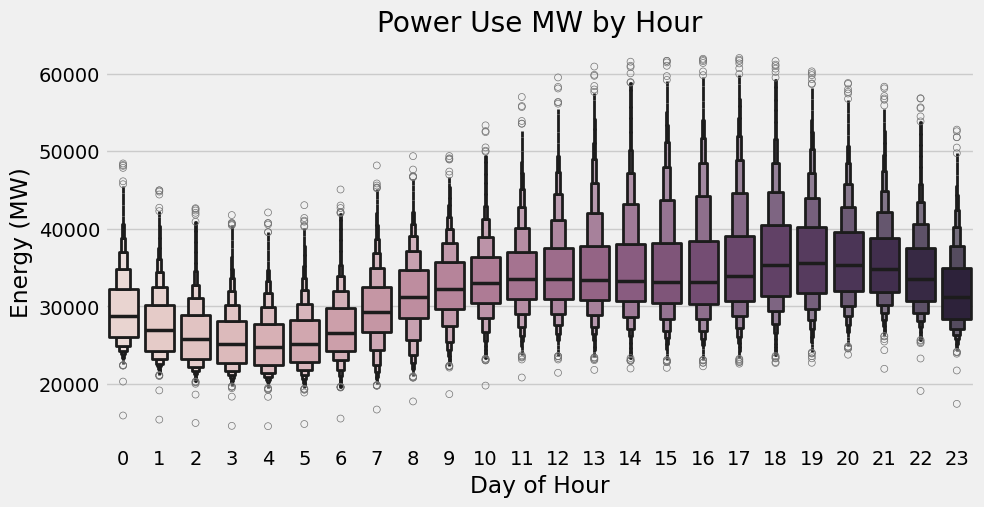

In [13]:
plot_time_range(df_features, 'hour')

### Energy Load Data Per Weekday

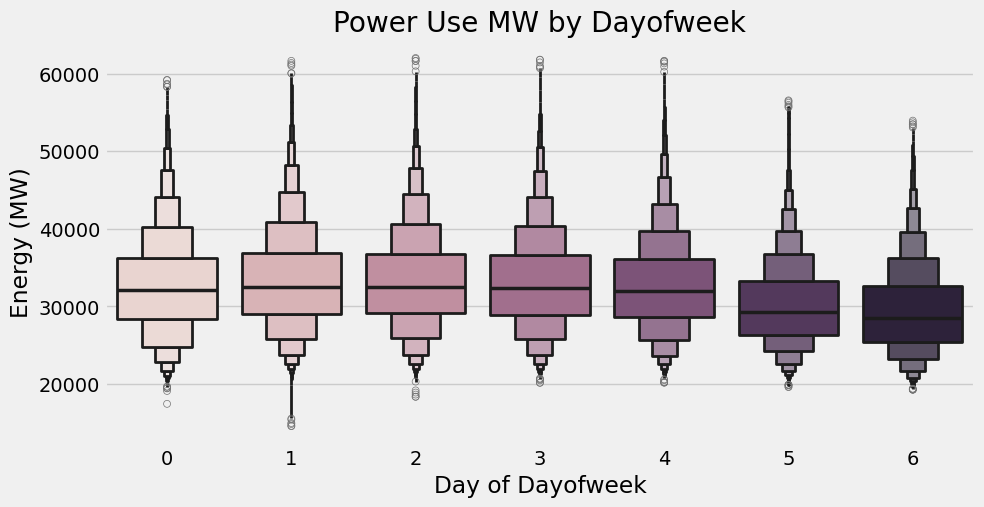

In [14]:
plot_time_range(df_features, 'dayofweek')

<Axes: xlabel='Datetime'>

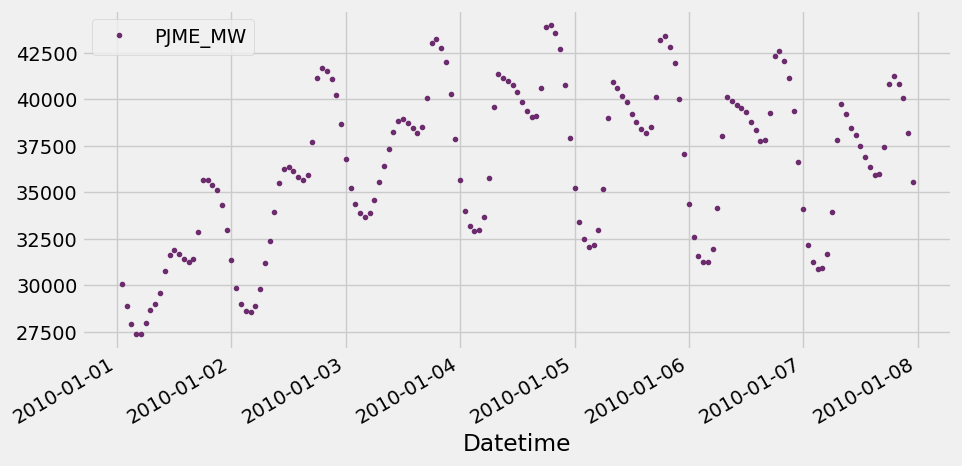

In [15]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(style='o', figsize=(10, 5), ms=3, color=colour_pal[5])

### Energy Load Data By Month

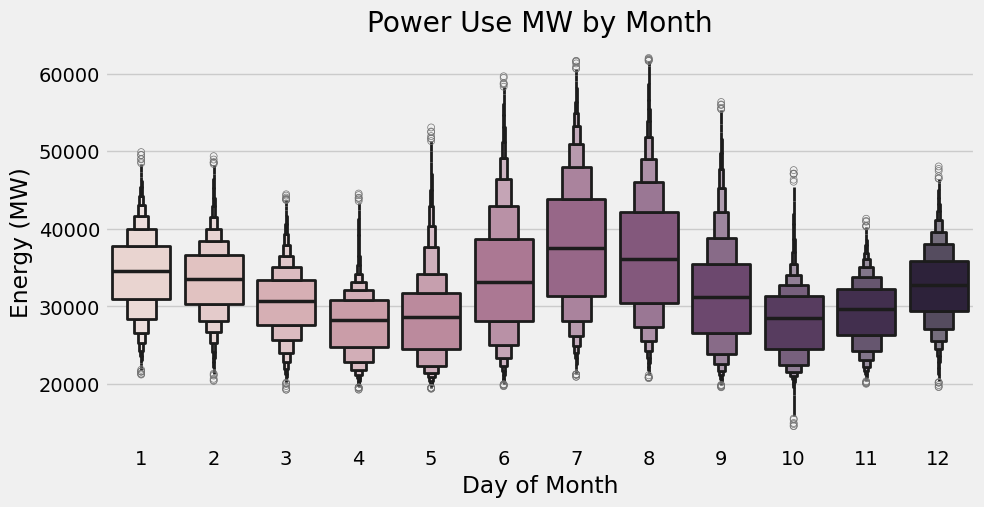

In [16]:
plot_time_range(df_features, 'month')

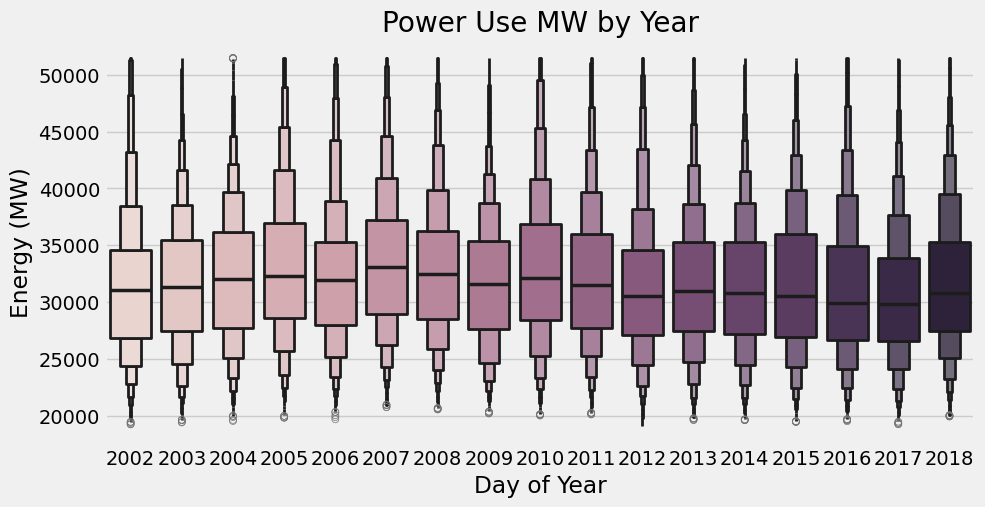

In [19]:
plot_time_range(df_features, 'year')

### Seasonality

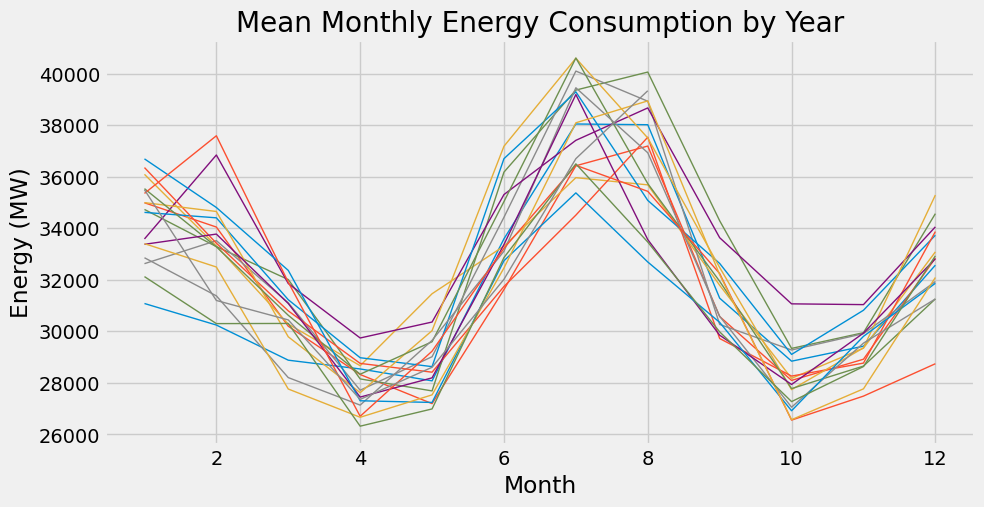

In [17]:
plot_mean_monthly(df_features)

## Plot Train/Test Split Data

In [18]:
df_train = df.loc[df.index < TARGET_CUTOFF_DATE].copy()
df_test = df.loc[df.index >= TARGET_CUTOFF_DATE].copy()

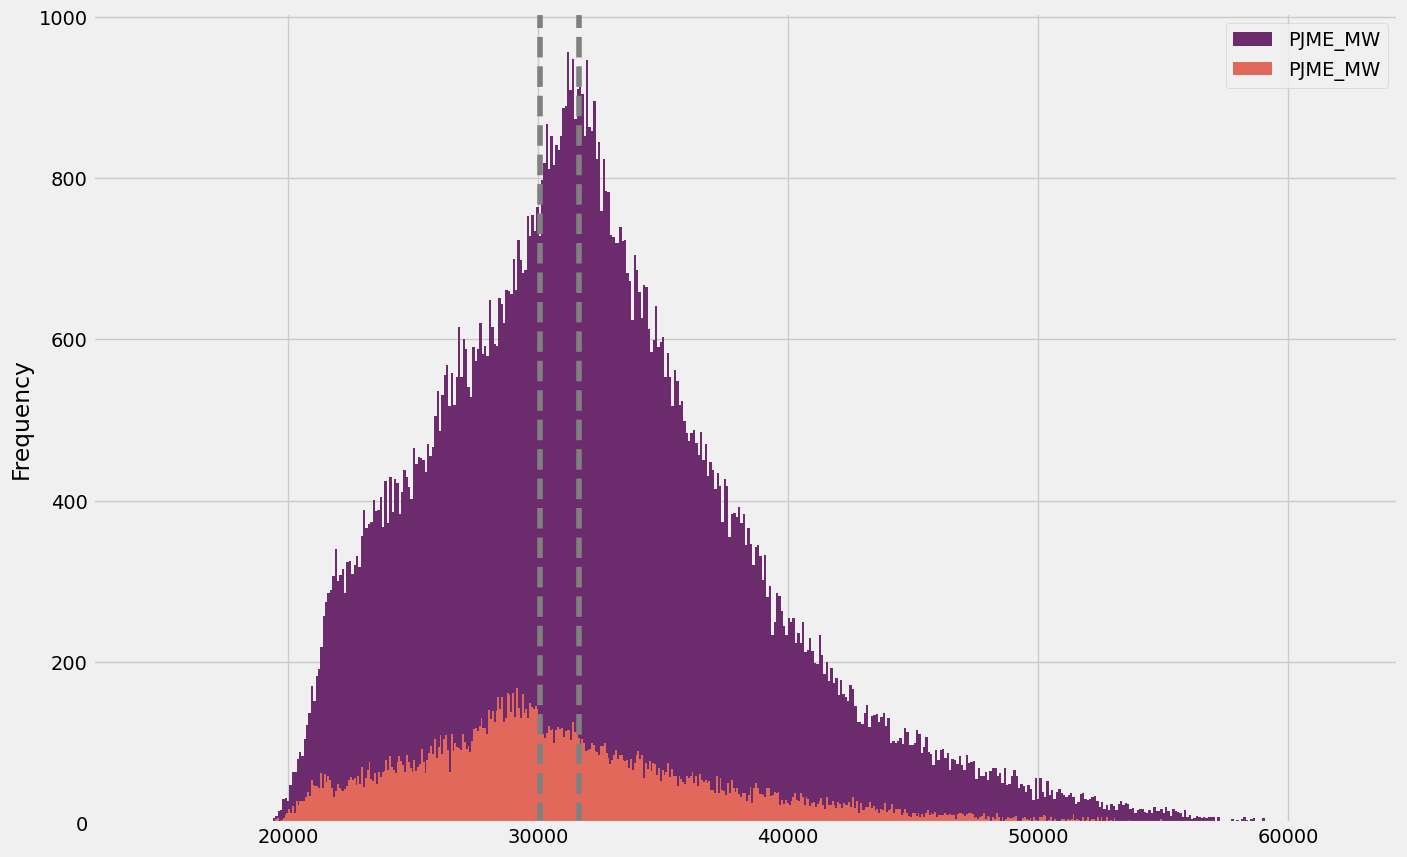

<Figure size 640x480 with 0 Axes>

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
df_train.plot(kind='hist', bins=500, color=colour_pal[5], ax=ax)
df_test.plot(kind='hist', bins=500, color=colour_pal[1], ax=ax)
plt.axvline(np.median(df_train['PJME_MW']), color='grey', ls='--')
plt.axvline(np.median(df_test['PJME_MW']), color='grey', ls='--')
plt.show()
plt.clf()

In [23]:
df_train.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [24]:
df_test.head()

,PJME_MW
Datetime,
2016-01-01 00:00:00,26686.0
2016-12-31 01:00:00,29627.0
2016-12-31 02:00:00,28744.0
2016-12-31 03:00:00,28274.0
2016-12-31 04:00:00,28162.0


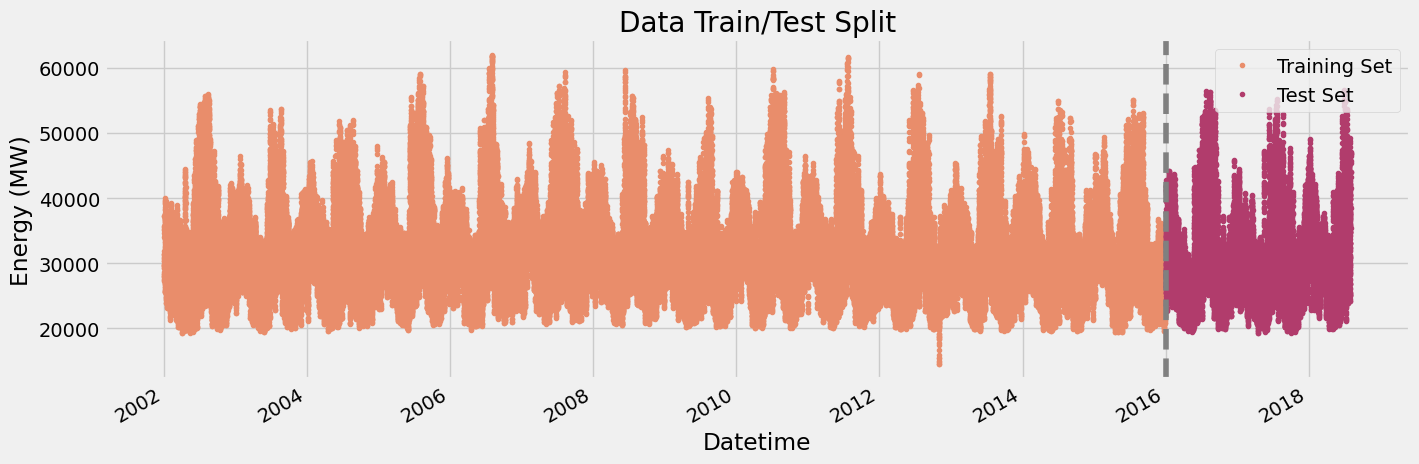

In [20]:
plot_train_test_split(df, TARGET_CUTOFF_DATE)

## Initial Model Building

Create features for train and test data

In [21]:
train = create_timeseries_features(df_train)
test = create_timeseries_features(df_test)
train.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


Create target and features for train and test data

In [22]:
train['weekofyear'] = train['weekofyear'].astype('int32')
test['weekofyear'] = test['weekofyear'].astype('int32')

In [23]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'weekofyear','quarter' ,'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [24]:
X_train.head()

,dayofyear,hour,dayofweek,weekofyear,quarter,month,year
Datetime,,,,,,,
2002-12-31 01:00:00,365,1,1,1,4,12,2002
2002-12-31 02:00:00,365,2,1,1,4,12,2002
2002-12-31 03:00:00,365,3,1,1,4,12,2002
2002-12-31 04:00:00,365,4,1,1,4,12,2002
2002-12-31 05:00:00,365,5,1,1,4,12,2002


In [25]:
y_train.head()

Datetime
2002-12-31 01:00:00    26498.0
2002-12-31 02:00:00    25147.0
2002-12-31 03:00:00    24574.0
2002-12-31 04:00:00    24393.0
2002-12-31 05:00:00    24860.0
Name: PJME_MW, dtype: float64

In [26]:
X_test.head()

,dayofyear,hour,dayofweek,weekofyear,quarter,month,year
Datetime,,,,,,,
2016-01-01 00:00:00,1,0,4,53,1,1,2016
2016-12-31 01:00:00,366,1,5,52,4,12,2016
2016-12-31 02:00:00,366,2,5,52,4,12,2016
2016-12-31 03:00:00,366,3,5,52,4,12,2016
2016-12-31 04:00:00,366,4,5,52,4,12,2016


In [27]:
y_test.head()

Datetime
2016-01-01 00:00:00    26686.0
2016-12-31 01:00:00    29627.0
2016-12-31 02:00:00    28744.0
2016-12-31 03:00:00    28274.0
2016-12-31 04:00:00    28162.0
Name: PJME_MW, dtype: float64

## Train Model

This is the first round of training, following the initial xgboost documentation and using the default parameters.

Regressor Parameters:

- base_score: 
initial prediction score for all instances, has effect on models convergence speed and accuracy (convergence speed is faster for higher values)

- booster: 
type of model to run at each iteration (default=gbtree), other options are gblinear and dart. Tree models are generally the best option because they are more flexible and can capture complex patterns in the data. (prone to overfitting)

- n_estimators: 
number of boosting rounds (can be cause of overfitting)

- early_stopping_rounds:
number of rounds without improvement after which the model will stop training (prevents overfitting)

- objective:
loss function to be minimized, i.e the function that the model will try to optimize in this case reg:linear because it is a regression problem with a linear output

- max_depth:
maximum depth of the tree, controls the complexity of the tree model (may cause overfitting if too high)

- learning_rate: 
step size shrinkage used to prevent overfitting, range is [0,1] (smaller values are better, but require more boosting rounds, higher values can cause overfitting)

- gamma:
minimum loss reduction required to make a further partition on a leaf node of the tree (higher values lead to fewer splits and more conservative models)

- reg_alpha:
L1 regularization term on weights (higher values lead to more conservative models adding more penalty to the weights), helps to reduce overfitting
- reg_lambda:
L2 regularization term on weights (higher values lead to more conservative models adding more penalty to the weights), helps to reduce overfitting

In [28]:
xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, early_stopping_rounds=50, objective="reg:linear" , max_depth=6, learning_rate=0.01, min_child_weight=1, subsample=0.8, colsample_bytree=0.8, gamma=0,reg_alpha=0, reg_lambda=1, random_state=42)

xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)


[0]	validation_0-rmse:32564.10345	validation_1-rmse:31495.54593


/Users/sjo/miniforge3/envs/playground/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:25:57] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12378.47501	validation_1-rmse:11535.00010
[200]	validation_0-rmse:5401.03465	validation_1-rmse:5187.65628
[300]	validation_0-rmse:3373.01864	validation_1-rmse:3978.09272
[400]	validation_0-rmse:2885.17694	validation_1-rmse:3943.79651
[402]	validation_0-rmse:2880.20143	validation_1-rmse:3945.45052


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance

Calculated as the average gain of each feature across all boosting rounds

The higher the gain, the more important the feature is in making predictions

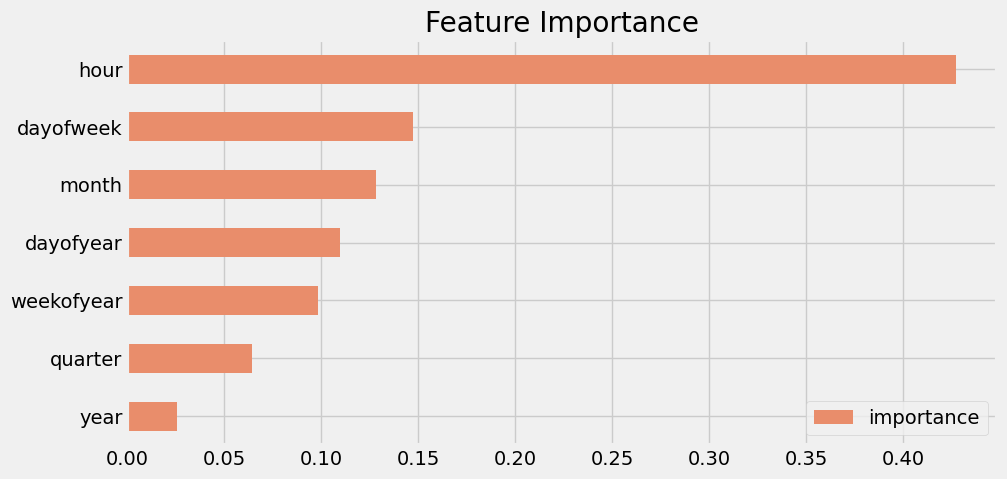

In [29]:
plot_feature_importance(xgb_model)

The model relies most on the hour feature, followed by the dayofweek and the month.

Note: All features are highly correlated with the target variable as they are all time-based features.

## Predictions Using Test Data

In [30]:
test['prediction'] = xgb_model.predict(X_test)
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2016-01-01 00:00:00,26686.0,0,4,1,1,2016,1,1,53,29689.458984
2016-12-31 01:00:00,29627.0,1,5,4,12,2016,366,31,52,24934.998047
2016-12-31 02:00:00,28744.0,2,5,4,12,2016,366,31,52,23666.095703
2016-12-31 03:00:00,28274.0,3,5,4,12,2016,366,31,52,23389.542969
2016-12-31 04:00:00,28162.0,4,5,4,12,2016,366,31,52,23389.542969


### Visualizing Predictions vs Actuals

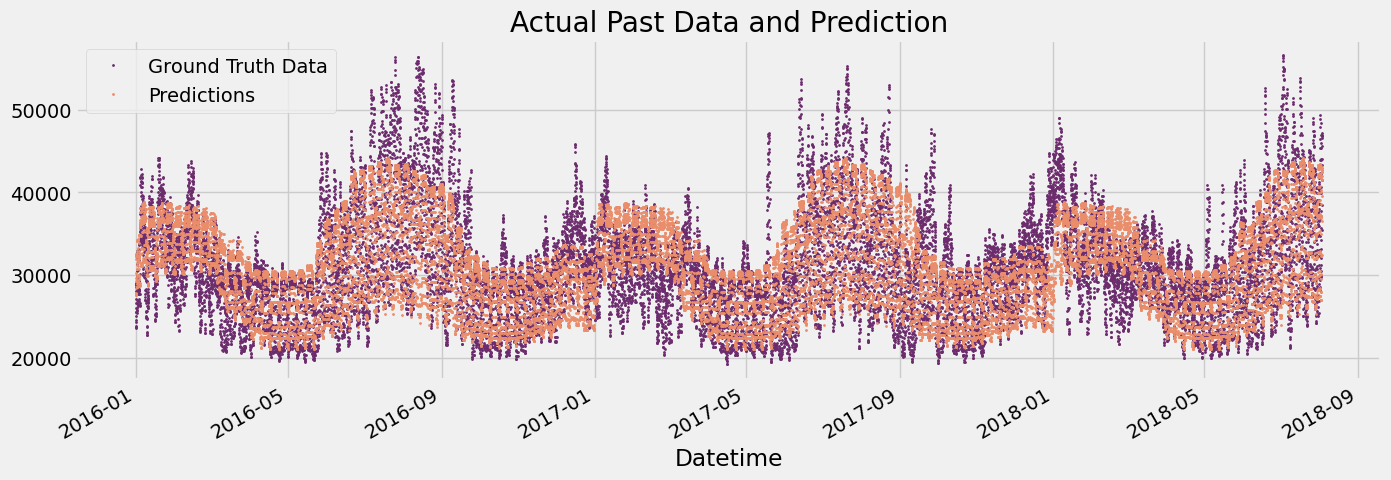

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
test['PJME_MW'].plot(ax=ax, style='o', ms=1, color=colour_pal[5])

test['prediction'].plot(ax=ax, style='o', ms=1 ,color=colour_pal[0])
plt.legend(['Ground Truth Data', 'Predictions'])
ax.set_title('Actual Past Data and Prediction')
plt.show()

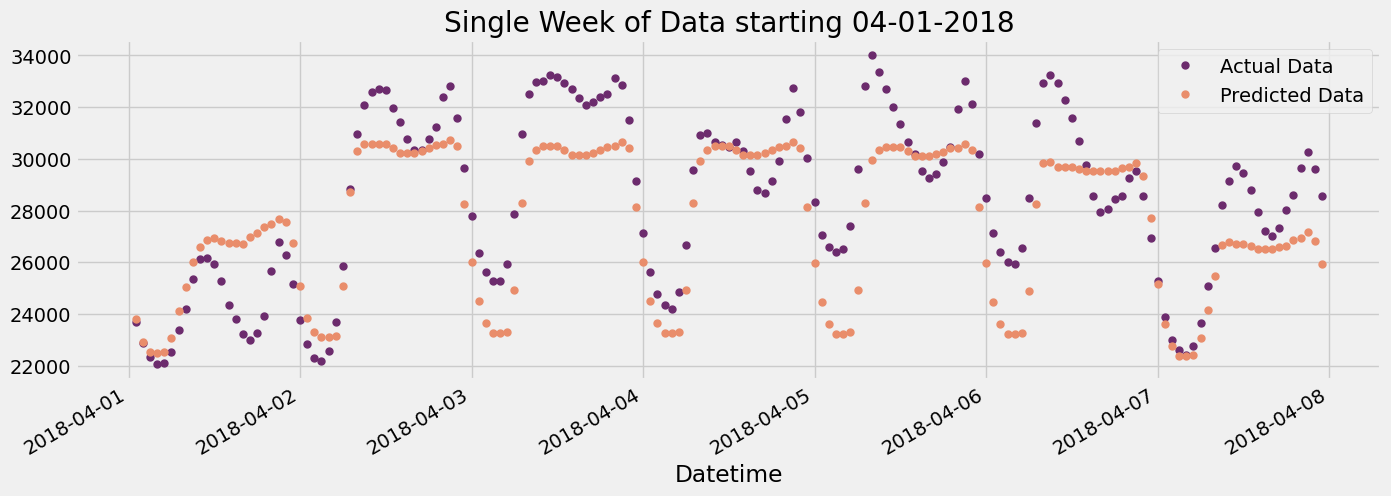

In [37]:
# select data within a week
data = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]
predictions = test.loc[(test.index > '04-01-2018') & (test.index < '04-08-2018')]
# plot the actual and predicted data
ax = data['PJME_MW'].plot(figsize=(
    15, 5), title='Single Week of Data starting 04-01-2018', linewidth=2, markersize=5, style='o',color=colour_pal[5])

predictions['prediction'].plot(
    style='o', linewidth=2, markersize=5, color=colour_pal[0])

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()

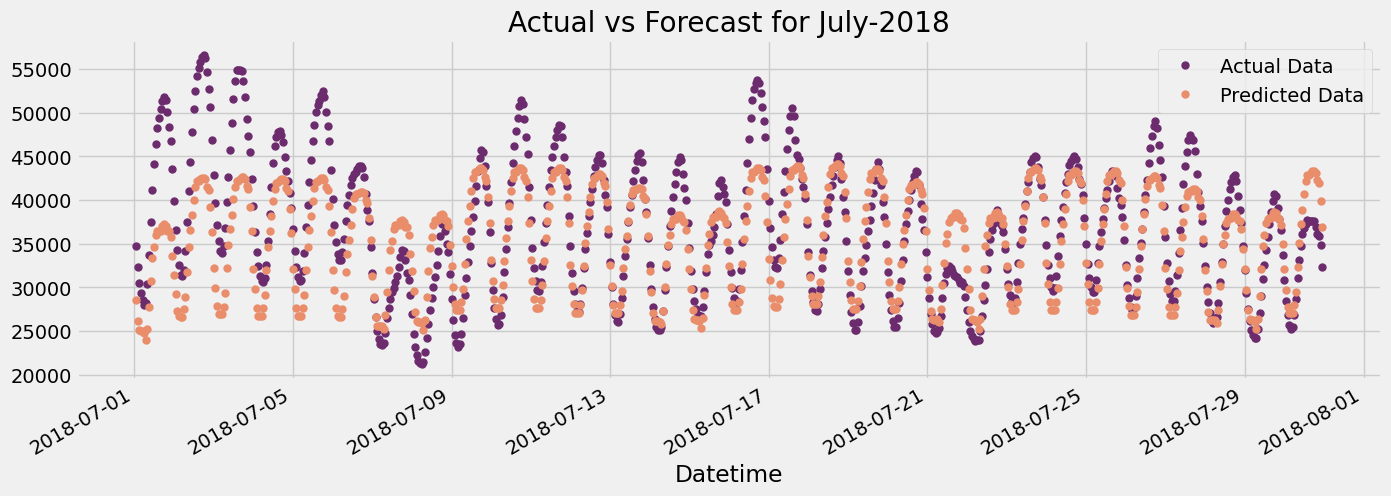

In [32]:
# select data within a specific date range
data = df.loc[(df.index > '07-01-2018') & (df.index < '07-31-2018')]
predictions = test.loc[(test.index > '07-01-2018') &
                       (test.index < '07-31-2018')]
# plot the actual portion
ax = data['PJME_MW'].plot(figsize=(
    15, 5), title='Actual vs Forecast for July-2018', style='o', markersize=5, color=colour_pal[5])

# plot the predicted portion
predictions['prediction'].plot(style='o', linewidth=2,
                        markersize=5, color=colour_pal[0])

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()

## Initial RMSE

In [33]:
score = root_mean_squared_error(test['PJME_MW'], test['prediction'])
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3918.30


## Forcasting Horizon & Lag Features

- The length of time into the future for which forecastes are made is called the forecasting horizon.
- Generally short-term forecasts are more accurate than long-term forecasts.
- Lag features are the values of the target variable at previous time steps. They are used to capture the temporal dependencies in the data.
    - For example, what was the target (x) days in the past

In [34]:
target_map = df['PJME_MW'].to_dict()
df_features = add_lags(df_features, target_map)

In [35]:
df_features.tail().T

Datetime,2018-01-01 20:00:00,2018-01-01 21:00:00,2018-01-01 22:00:00,2018-01-01 23:00:00,2018-01-02 00:00:00
PJME_MW,44284.0,43751.0,42402.0,40164.0,38608.0
hour,20,21,22,23,0
dayofweek,0,0,0,0,1
quarter,1,1,1,1,1
month,1,1,1,1,1
year,2018,2018,2018,2018,2018
dayofyear,1,1,1,1,2
dayofmonth,1,1,1,1,2
weekofyear,1,1,1,1,1
lag1,34600.0,33674.0,32035.0,29870.0,27771.0


## Cross Validation

In [36]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

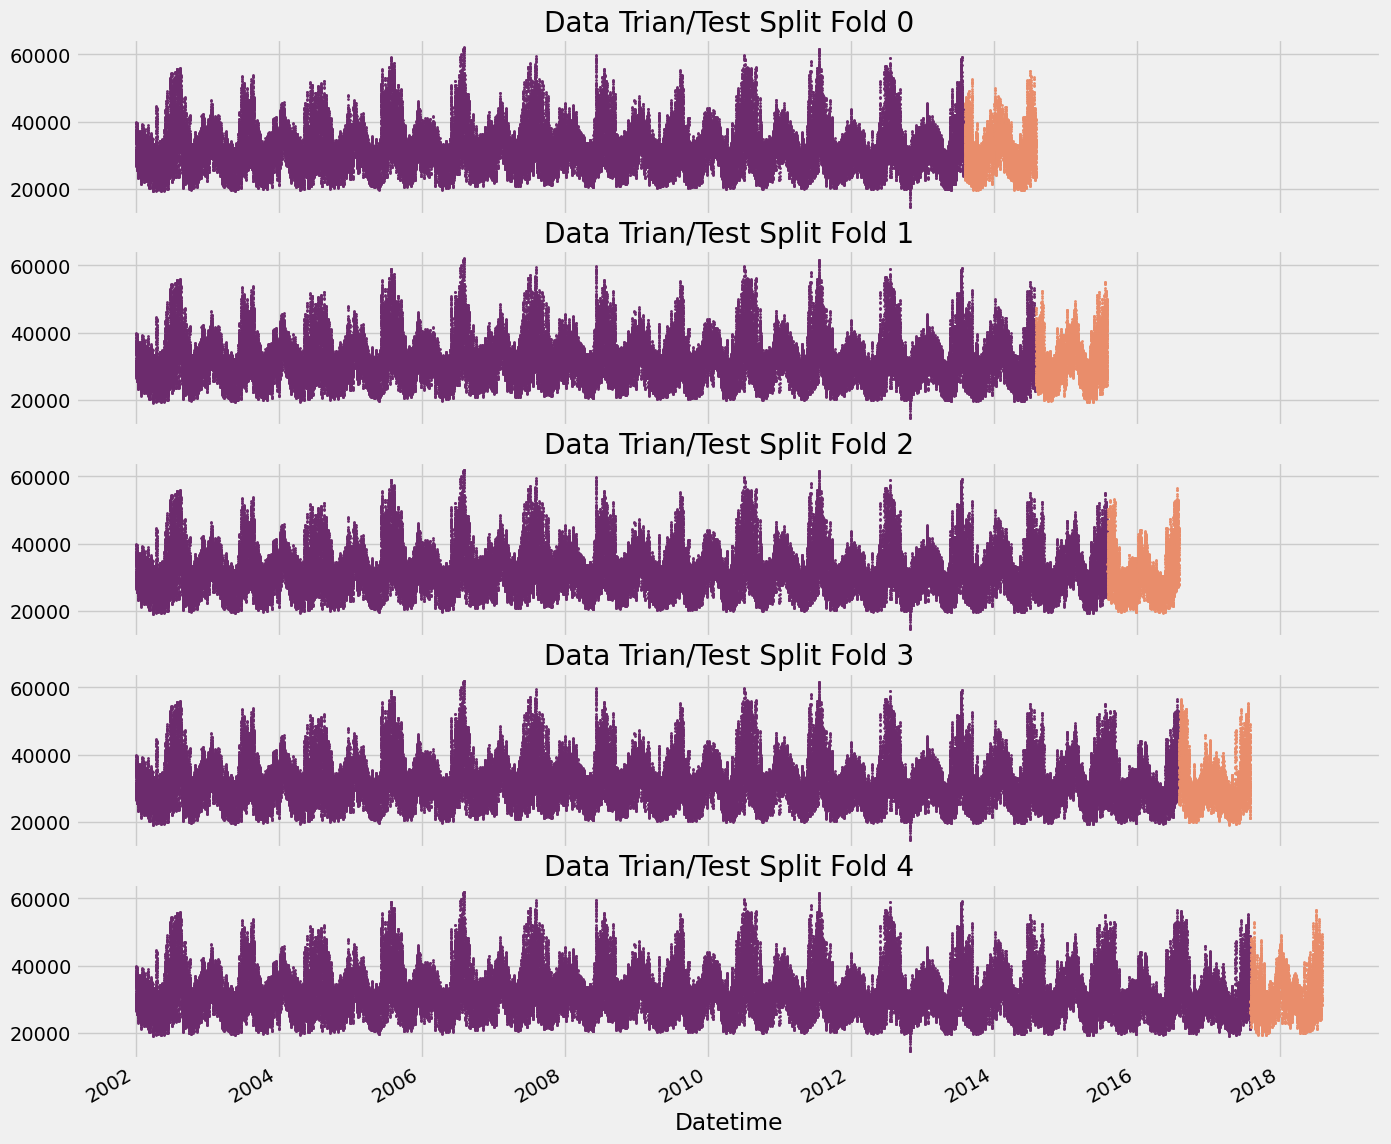

In [37]:
fig, ax = plt.subplots(5,1,figsize=(15, 15), sharex=True)
fold = 0
for train_index, test_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    train['PJME_MW'].plot(ax=ax[fold],label='Training Set', title=f'Data Trian/Test Split Fold {fold}', style='o', ms=1, color=colour_pal[5])
    test['PJME_MW'].plot(ax=ax[fold],label='Test Set', style='o', ms=1, color=colour_pal[0])
    fold += 1

### Train Model Using Cross Validation & Lag Features

In [38]:
scores, pred, xgb_model = cross_validation(df)


[0]	validation_0-rmse:32729.88462	validation_1-rmse:31957.74561


/Users/sjo/miniforge3/envs/playground/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:28:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12410.60836	validation_1-rmse:12038.60727
[200]	validation_0-rmse:5393.00911	validation_1-rmse:5546.24385
[300]	validation_0-rmse:3368.25535	validation_1-rmse:4017.11264
[400]	validation_0-rmse:2889.98677	validation_1-rmse:3791.67147
[500]	validation_0-rmse:2727.03672	validation_1-rmse:3740.93484
[600]	validation_0-rmse:2620.19801	validation_1-rmse:3720.31385
[673]	validation_0-rmse:2558.43792	validation_1-rmse:3724.82756


In [39]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 31252.6719
Fold scores:[array([36795.176, 34339.582, 31787.871, ..., 40491.504, 38033.73 ,
       33613.098], dtype=float32)]


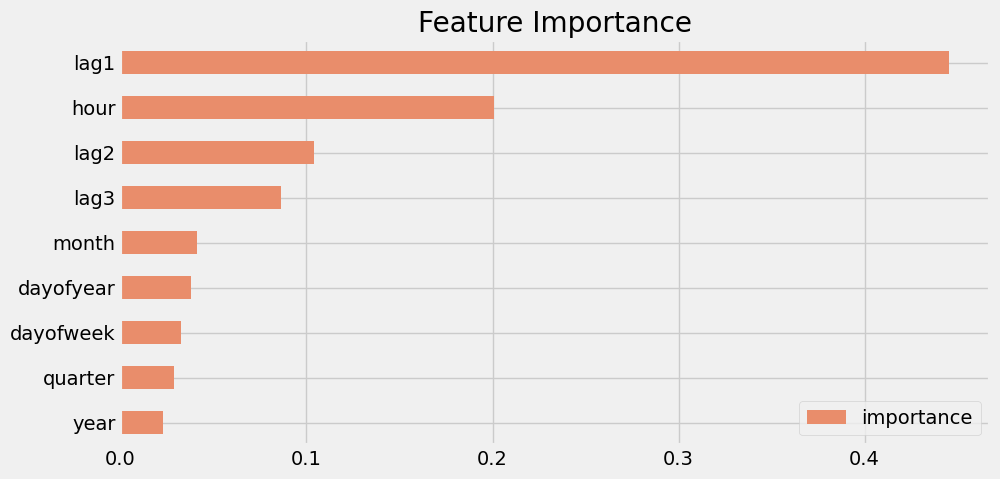

In [40]:
plot_feature_importance(xgb_model)

## Tuning Hyperparameters

- The hyperparameters are tuned using RandomizedSearchCV
- Tree structure parameters are tuned first, followed by regularization parameters

In [46]:
hyperparameters = {
    'n_estimators': [500, 1000],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.01, 0.1],
    'reg_alpha': [0, 1],
    'reg_lambda': [0, 1],    
}

In [47]:
results = tune_hyperparameters(df, hyperparameters, TARGET_CUTOFF_DATE, 30)

[0]	validation_0-rmse:6419.09064	validation_1-rmse:6433.86844
[100]	validation_0-rmse:3864.10724	validation_1-rmse:4299.85284
[200]	validation_0-rmse:3131.59009	validation_1-rmse:4005.94245
[300]	validation_0-rmse:2863.02135	validation_1-rmse:4058.11110
[400]	validation_0-rmse:2726.19200	validation_1-rmse:4132.17773
[499]	validation_0-rmse:2597.15926	validation_1-rmse:4195.89116
[0]	validation_0-rmse:6017.74021	validation_1-rmse:6070.90038
[100]	validation_0-rmse:2214.46338	validation_1-rmse:4349.00153
[200]	validation_0-rmse:1821.00641	validation_1-rmse:4419.24976
[300]	validation_0-rmse:1598.61276	validation_1-rmse:4463.63881
[400]	validation_0-rmse:1433.09736	validation_1-rmse:4504.81050
[500]	validation_0-rmse:1313.40247	validation_1-rmse:4502.70879
[600]	validation_0-rmse:1211.13526	validation_1-rmse:4528.53277
[700]	validation_0-rmse:1117.17064	validation_1-rmse:4540.71828
[800]	validation_0-rmse:1050.99468	validation_1-rmse:4540.35368
[900]	validation_0-rmse:985.08749	validation

In [48]:
results.sort_values(by='score', ascending=True).head()

,n_estimators,max_depth,learning_rate,reg_alpha,reg_lambda,score
15,500,5,0.01,1,0,4160.525949
16,500,5,0.01,1,1,4162.626665
9,500,5,0.01,0,0,4166.395335
26,500,6,0.01,1,1,4169.090128
19,500,6,0.01,0,1,4169.090317


## Forecasting

- retaining the last 24 hours of the training data to use as lag features for the first 24 hours of the test data
- using the model to predict the next 24 hours of energy load
- adding the predictions to the training data and repeating the process for the next 24 hours

In [60]:
df = create_timeseries_features(df)
df = add_lags(df, target_map)

X_all = df[FEATURES]
y_all = df[TARGET]

model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, early_stopping_rounds=50, objective="reg:linear", max_depth=5, learning_rate=0.1, min_child_weight=1, subsample=0.8, colsample_bytree=0.8, gamma=0,reg_alpha=1, reg_lambda=1, random_state=42)

model.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:29500.96998


/Users/sjo/miniforge3/envs/playground/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:46:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2759.01047
[200]	validation_0-rmse:2465.44749
[300]	validation_0-rmse:2275.71770
[400]	validation_0-rmse:2136.57286
[500]	validation_0-rmse:2024.89959
[600]	validation_0-rmse:1936.74474
[700]	validation_0-rmse:1867.83326
[800]	validation_0-rmse:1805.52874
[900]	validation_0-rmse:1748.83525
[999]	validation_0-rmse:1694.17399


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [61]:
df.index.max() 

Timestamp('2018-08-03 00:00:00')

In [62]:
future_dates = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future_dates)
future_df['is_future'] = 1
df['is_future'] = 0
df_all = pd.concat([df, future_df])
df_all = create_timeseries_features(df_all)
df_all = add_lags(df_all, target_map)

In [63]:
future_with_features = df_all.query('is_future == 1').copy()

In [64]:
future_with_features.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,is_future
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,1
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,1
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,1
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,1
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,1


### Predicting the Future Energy Load

In [65]:
future_with_features['prediction'] = model.predict(future_with_features[FEATURES])

In [66]:
future_with_features.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,is_future,prediction
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,1,36152.664062
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,1,33521.351562
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,1,31582.355469
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,1,30588.210938
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,1,29954.867188


<Axes: title={'center': 'Future Predictions'}>

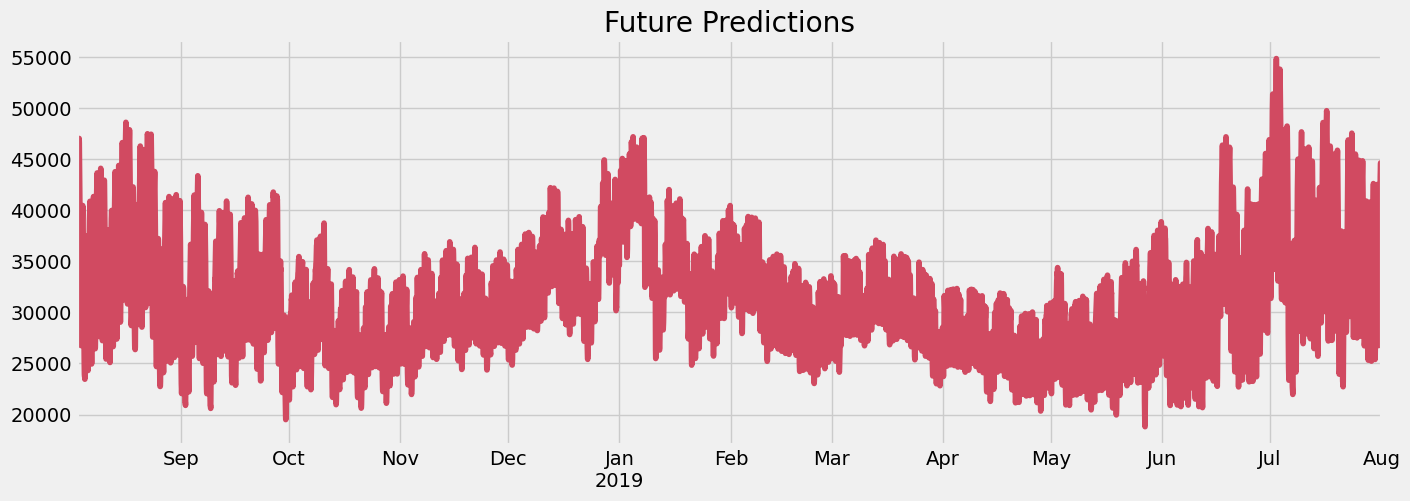

In [67]:
future_with_features['prediction'].plot(figsize=(15, 5), style='-', ms=1, color=colour_pal[2], title='Future Predictions')

## Saving Model

In [68]:
model.save_model('energyload_model.json')

## Improvements

- use an additive model to capture the seasonality and trend in the data
- use a more complex model to capture the non-linear relationships in the data (Example: ARIMA, LSTM)
- integrate temperature data to improve the model